### How to organize DSSD-like events 

#### 通常的做法:  将数据储存在数组.

For 3 DSSDs with 32x32 for each det:

energy:xe[3][32],ye[3][32];

time: xt[3][32],yt[3][32];

绝大多数情况下，一个DSSD只有少数条包含有用的信息，数组中大多数元素是无用的。另外数组结构不利于表达DSSD的整体特性，如无法一次检查一个DSSD中多个条的能量信息。
我们将在DSSD的front-back side correlation部分看到更多的应用。

In [1]:
TFile *ipf=new TFile("t0alpha.root");
TTree *ipt=(TTree*)ipf->Get("tree");

In [2]:
ipt->Show(0);

======> EVENT:0
 t0d1x           = 0, 
                  42, 0, 46, 0, 44, 0, 45, 162, 0, 0, 
                  0, 0, 0, 0, 0, 0, 0, 0, 0
 t0d1y           = 0, 
                  35, 0, 34, 0, 33, 0, 35, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0, 49, 0, 46
 t0d2x           = 0, 
                  47, 41, 45, 0, 42, 0, 41, 178, 44, 40, 
                  42, 0, 44, 0, 44, 0, 44, 0, 44
 t0d2y           = 0, 
                  0, 0, 41, 0, 46, 0, 43, 0, 42, 0, 
                  0, 0, 0, 0, 42, 41, 43, 0, 42
 t0d3x           = 0, 
                  46, 0, 47, 0, 46, 0, 46, 44, 45, 0, 
                  41, 0, 44, 0, 42, 0, 41, 0, 45
 t0d3y           = 0, 
                  45, 0, 44, 0, 47, 0, 50, 0, 41, 0, 
                  44, 0, 45, 0, 42, 0, 47, 0, 49
 run             = 3670
 nevt            = 0


In [3]:
ipf->Close();

### 利用hit结构-动态数组的表达方法

In [4]:

ipf=new TFile("t0alpha.root");
ipt=(TTree*)ipf->Get("tree");

int t0d1x[32], t0d2x[32], t0d3x[32];
int t0d1y[32], t0d2y[32], t0d3y[32];

ipt->SetBranchAddress("t0d1x",&t0d1x);
ipt->SetBranchAddress("t0d1y",&t0d1y);
ipt->SetBranchAddress("t0d2x",&t0d2x);
ipt->SetBranchAddress("t0d2y",&t0d2y);
ipt->SetBranchAddress("t0d3x",&t0d3x);
ipt->SetBranchAddress("t0d3y",&t0d3y);

//为了简化，下列代码中不同探测器的x,y信号分别按照xhit，yhit记录
//实际应用中每个探测器的x,y信号都应分别进行记录如，d1xhit,d1yhit
//这时，每个hit数代表每个探测器的每一面的多重性。
// x-side
int xhit;//有效信号的xstrip数目
int xdet[3*32];  //探测器编号, 每个数组维数必须大于最大的xhit数
int xstrip[3*32]; //条编号0-31; 
double xe[3*32];//能量
//double xt[3*32]; //时间
//y-side
int yhit;
int ydet[3*32];  
int ystrip[3*32]; 
double ye[3*32];//能量
//double yt[3*32]; //时间
TFile *opf=new TFile("alphahit.root","recreate");
TTree *opt=new TTree("tree","alpha hit");
//可变数组作为Branch的写法
opt->Branch("xhit",&xhit,"xhit/I");             //必须将可变数组维数xhit作为一个branch
opt->Branch("xdet",&xdet,"xdet[xhit]/I");    //数组维数=hit
opt->Branch("xstrip",&xstrip,"xstrip[xhit]/I"); //数组维数=hit
opt->Branch("xe",&xe,"xe[xhit]/D");            //数组维数=hit
//tree->Branch("xt",&xt,"xt[xhit]/D");

opt->Branch("yhit",&yhit,"yhit/I");             //必须将可变数组维数xhit作为一个branch
opt->Branch("ydet",&ydet,"ydet[yhit]/I");    //数组维数=hit
opt->Branch("ystrip",&ystrip,"ystrip[yhit]/I"); //数组维数=hit
opt->Branch("ye",&ye,"ye[yhit]/D");            //数组维数=hit
//tree->Branch("yt",&yt,"yt[yhit]/D");
Long64_t nentries = ipt->GetEntriesFast();
for (Long64_t jentry=0; jentry<nentries;jentry++) {
    xhit=0; yhit=0;//初始化
    ipt->GetEntry(jentry);
    for(int i=0;i<32;i++) {//如果有时间信息，还需要加上有效时间条件
       if(t0d1x[i]>10) {
           xdet[xhit]=0; xstrip[xhit]=i; xe[xhit]=t0d1x[i];
           xhit++;
       }
       if(t0d1y[i]>10) {
           ydet[yhit]=0; ystrip[yhit]=i; ye[yhit]=t0d1y[i];
           yhit++;
       }    
       if(t0d2x[i]>10) {
           xdet[xhit]=1; xstrip[xhit]=i; xe[xhit]=t0d2x[i];
           xhit++;           
       }
       if(t0d2y[i]>10) {
           ydet[yhit]=1; ystrip[yhit]=i; ye[yhit]=t0d2y[i];
           yhit++;
       }  
       if(t0d3x[i]>10) {
           xdet[xhit]=2; xstrip[xhit]=i; xe[xhit]=t0d3x[i];
           xhit++;
       }
       if(t0d3y[i]>10) {
           ydet[yhit]=2; ystrip[yhit]=i; ye[yhit]=t0d3y[i];
           yhit++;
       }  
    }
    opt->Fill(); 
    if(jentry%500000==0) cout<<jentry<<endl;
}
opt->Write();
opf->Close();
ipf->Close();


0
500000
1000000
1500000


In [5]:
ipf=new TFile("alphahit.root");
ipt=(TTree*)ipf->Get("tree");
ipt->Print();

******************************************************************************
*Tree    :tree      : alpha hit                                              *
*Entries :  1501781 : Total =       113113198 bytes  File  Size =   36956198 *
*        :          : Tree compression factor =   3.06                       *
******************************************************************************
*Br    0 :xhit      : xhit/I                                                 *
*Entries :  1501781 : Total  Size=    6020984 bytes  File Size  =    1029326 *
*Baskets :      149 : Basket Size=    1281536 bytes  Compression=   5.85     *
*............................................................................*
*Br    1 :xdet      : xdet[xhit]/I                                           *
*Entries :  1501781 : Total  Size=   10699243 bytes  File Size  =    3211876 *
*Baskets :      414 : Basket Size=   25600000 bytes  Compression=   3.33     *
*...................................................

In [6]:
tree->Show(1);

======> EVENT:1
 xhit            = 4
 xdet            = 2, 
                  1, 2, 2
 xstrip          = 1, 
                  6, 9, 21
 xe              = 44, 
                  149, 39, 43
 yhit            = 8
 ydet            = 2, 
                  2, 2, 2, 2, 2, 1, 2
 ystrip          = 1, 
                  5, 6, 11, 18, 24, 26, 28
 ye              = 43, 
                  44, 47, 39, 46, 50, 
                  156, 46


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


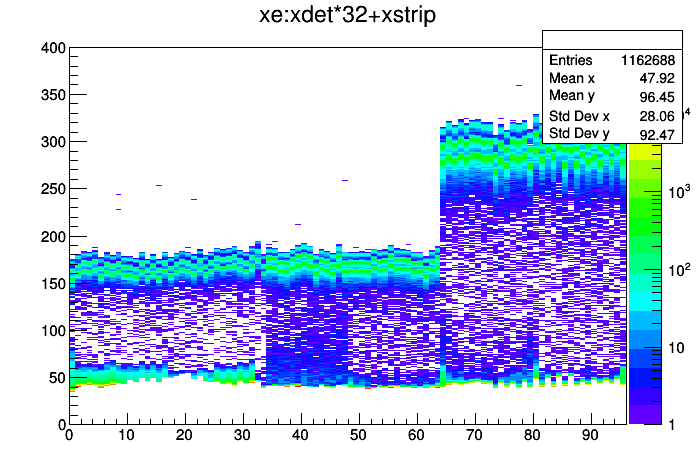

In [7]:
tree->Draw("xe:xdet*32+xstrip>>(96,0,96,400,0,400)","","colz");
gStyle->SetPalette(1);
c1->SetLogz();
c1->Draw();

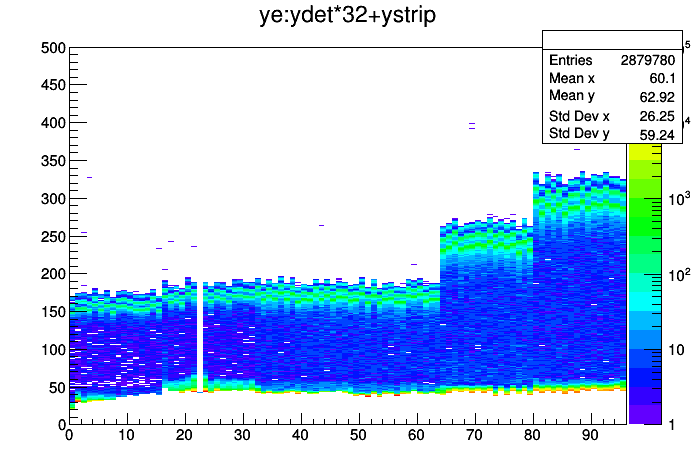

In [8]:
tree->Draw("ye:ydet*32+ystrip>>(96,0,96,500,0,500)","","colz");
gStyle->SetPalette(1);
c1->SetLogz();
c1->Draw();

#### 做完能量刻度后每个strip的对应的alpha能量应该在一条线上(与x轴平行)